In [1]:
from pathlib import Path

from rich.console import Console
from rich.table import Table

from numpy import loadtxt

from numpy import float32, bool as np_bool
from numpy.typing import NDArray
from typing import Any
from collections.abc import Callable

In [2]:
from numpy import mean, diff, sqrt, pi, linspace

from backscattering_analyzer.experiment import Experiment
from backscattering_analyzer.acquisition import AcquisitionType

from matplotlib.pyplot import figure, show

from science_signal import Signal
from science_signal.generator import sin as sin_gen

In [3]:
def is_over(signal1: Signal, signal2: Signal) -> bool:
    """
    True if signal1 is over signal2
    """
    return not ((signal1 - signal2).y < 0).any()


def get_speed(signal: Signal) -> NDArray[float32]:
    """
    get speed from position signal
    """
    return 1 / mean(diff(signal.x)) * diff(signal.y)


def compute_rms(signal: NDArray[float32]) -> float:
    """
    compute RMS of data
    """
    return sqrt(mean(signal**2))  # pyright: ignore[reportAny]


def accelerate_timesignal(factor: float, signal: Signal) -> Signal:
    """
    accelerate a signal by a factor
    """
    return Signal(
        signal.x[0] + (signal.x - signal.x[0]) * (1 / factor),
        signal.y,
    )


def generate_movement(max_speed: float, start: int, end: int) -> Signal:
    """
    generate a sine movement with a given maximum speed
    """
    amplitude: float = sqrt(max_speed / (2 * pi))
    frequency: float = sqrt(max_speed / (2 * pi))
    signal = sin_gen(end - start, 1000, frequency, amplitude)
    return Signal(
        start + signal.x,
        signal.y,
    )


def fit_value(
    start: float,
    end: float,
    nb_loop: int,
    experiment: Experiment,
    reference: Signal,
    generate: Callable[[float, Any], Signal],
    condition: Callable[[Signal, Signal], np_bool | bool],
    generate_args: list[Any],
) -> float:
    """
    find the value that is the closest to NOT respecting the condition function
    Considering it start by not respecting the condition, and after some time, it will
    """
    for _ in range(nb_loop):
        values = linspace(start, end, 10, dtype=float32)
        detected = False
        for j in range(len(values)):
            value = values[j]
            experiment.reference_movement = generate(value, *generate_args)
            experiment.projection_reference = experiment.compute_projection(
                AcquisitionType.REFERENCE
            )
            if (
                not condition(reference, experiment.projection_reference)
                and not detected
            ):
                detected = True
                end = value
                start = values[j - 1]
        if not detected:
            raise Exception("not in range")
    return start + (end - start) / 2

In [4]:
console = Console()
o5_mat = (
    Path("/home/demagny/data")
    / "simulation"
    / "optickle"
    / "transfer_function"
    / "O5.mat"
)
sensitivities: dict[str, Signal] = dict()
for name in ["high", "low"]:
    data = loadtxt(
        Path(
            "/home/demagny/data/sensitivity/O5/23932_O5{}SensASD.txt".format(
                name.capitalize()
            )
        ),
        dtype=float32,
    )
    sensitivities[name] = Signal(
        data[:, 0],
        data[:, 1],
    )
sensitivities["high"].y /= 10

In [5]:
C_BENCH = "SDB1"
C_COUPLING = "../main_script_virgo/values-coupling.toml"

In [6]:
base_experiment = Experiment(C_BENCH, "2024_08_15", C_COUPLING, 0.1)
temp_experiment = Experiment(C_BENCH, "2024_08_15", C_COUPLING, 0.1)
base_experiment.factors = {"pre": 2e-10 * 1e6, "true": 2e-10}
temp_experiment.factors = {"pre": 2e-10 * 1e6, "true": 2e-10}
base_experiment.modelisation_file = str(o5_mat)
temp_experiment.modelisation_file = str(o5_mat)

no excited signal given, cannot get factors of the excited signal
no excited signal given, cannot get factors of the excited signal


In [ ]:
factor = default_rng().random(1) * 10
# check if frequency is multiplied by the factor after going into accelerate_timesignal function
assert abs(factor/mean(diff(base_experiment.reference_movement.x)) - 1/mean(diff(accelerate_timesignal(factor, base_experiment.reference_movement).x))) < 1e-1, abs(factor/mean(diff(base_experiment.reference_movement.x)) - 1/mean(diff(accelerate_timesignal(factor, base_experiment.reference_movement).x)))
# check if amplitude is not modified after going into accelerate_timesignal function
assert (base_experiment.reference_movement.y == accelerate_timesignal(factor, base_experiment.reference_movement).y).all(), base_experiment.reference_movement.y - accelerate_timesignal(factor, base_experiment.reference_movement).y

In [7]:
high_fitted_value = fit_value(
    1e-6,
    1e-5,
    5,
    temp_experiment,
    sensitivities["high"],
    generate_movement,
    is_over,
    [
        base_experiment.reference_movement.x[0],
        base_experiment.reference_movement.x[-1],
    ],
)
low_fitted_value = fit_value(
    1e-6,
    1e-5,
    5,
    temp_experiment,
    sensitivities["low"],
    generate_movement,
    is_over,
    [
        base_experiment.reference_movement.x[0],
        base_experiment.reference_movement.x[-1],
    ],
)

In [8]:
high_movement = generate_movement(
    high_fitted_value,
    base_experiment.reference_movement.x[0],
    base_experiment.reference_movement.x[-1],
)
temp_experiment.reference_movement = high_movement
high_projection = temp_experiment.compute_projection(AcquisitionType.REFERENCE)
low_movement = generate_movement(
    low_fitted_value,
    base_experiment.reference_movement.x[0],
    base_experiment.reference_movement.x[-1],
)
temp_experiment.reference_movement = low_movement
low_projection = temp_experiment.compute_projection(AcquisitionType.REFERENCE)

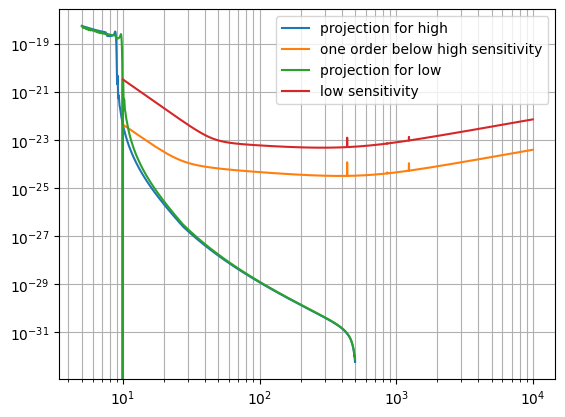

In [9]:
Figure = figure()
_ = Figure.gca().loglog(
    high_projection.x, high_projection.y, label="projection for high"
)
_ = Figure.gca().loglog(
    sensitivities["high"].x,
    sensitivities["high"].y,
    label="one order below high sensitivity",
)
_ = Figure.gca().loglog(low_projection.x, low_projection.y, label="projection for low")
_ = Figure.gca().loglog(
    sensitivities["low"].x, sensitivities["low"].y, label="low sensitivity"
)
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

In [10]:
table = Table(title="Vérification des calculs: haute sensibilité")
table.add_column("nom")
table.add_column("RMS")
table.add_column("vitesse max")

table.add_row(
    "calculé",
    "{:.2E}".format(high_fitted_value / sqrt(2)),
    "{:.2E}".format(high_fitted_value),
)
table.add_row(
    "mesuré",
    "{:.2E}".format(
        compute_rms(get_speed(high_movement)),
    ),
    "{:.2E}".format(
        max(get_speed(high_movement)),
    ),
)

console.print(table)

table = Table(title="Vérification des calculs: basse sensibilité")
table.add_column("nom")
table.add_column("RMS")
table.add_column("vitesse max")

table.add_row(
    "calculé",
    "{:.2E}".format(low_fitted_value / sqrt(2)),
    "{:.2E}".format(low_fitted_value),
)
table.add_row(
    "mesuré",
    "{:.2E}".format(
        compute_rms(get_speed(low_movement)),
    ),
    "{:.2E}".format(
        max(get_speed(low_movement)),
    ),
)

console.print(table)

  Vérification des calculs: haute   
            sensibilitée            
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ nom     ┃ RMS      ┃ vitesse max ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ calculé │ 3.33E-06 │ 4.71E-06    │
│ mesuré  │ 3.04E-06 │ 4.71E-06    │
└─────────┴──────────┴─────────────┘

  Vérification des calculs: basse   
            sensibilitée            
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ nom     ┃ RMS      ┃ vitesse max ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ calculé │ 3.66E-06 │ 5.18E-06    │
│ mesuré  │ 3.41E-06 │ 5.18E-06    │
└─────────┴──────────┴─────────────┘

# Utilisation du mouvement réel du banc

In [11]:
high_fitted_value = fit_value(
    0.5,
    3,
    5,
    temp_experiment,
    sensitivities["high"],
    accelerate_timesignal,
    is_over,
    [
        base_experiment.reference_movement,
    ],
)
low_fitted_value = fit_value(
    0.5,
    6,
    5,
    temp_experiment,
    sensitivities["low"],
    accelerate_timesignal,
    is_over,
    [
        base_experiment.reference_movement,
    ],
)

In [12]:
high_movement = accelerate_timesignal(
    high_fitted_value, base_experiment.reference_movement
)
low_movement = accelerate_timesignal(
    low_fitted_value, base_experiment.reference_movement
)
temp_experiment.reference_movement = high_movement
high_projection = temp_experiment.compute_projection(AcquisitionType.REFERENCE)
temp_experiment.reference_movement = low_movement
low_projection = temp_experiment.compute_projection(AcquisitionType.REFERENCE)

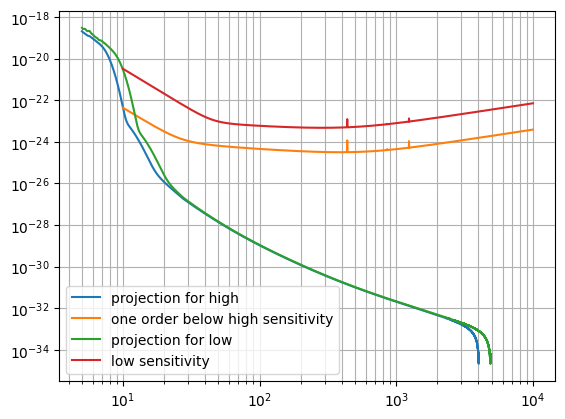

In [13]:
Figure = figure()
_ = Figure.gca().loglog(
    high_projection.x, high_projection.y, label="projection for high"
)
_ = Figure.gca().loglog(
    sensitivities["high"].x,
    sensitivities["high"].y,
    label="one order below high sensitivity",
)
_ = Figure.gca().loglog(low_projection.x, low_projection.y, label="projection for low")
_ = Figure.gca().loglog(
    sensitivities["low"].x, sensitivities["low"].y, label="low sensitivity"
)
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

In [17]:
table = Table(title="Vérification des calculs: haute sensibilité")
table.add_column("nom")
table.add_column("RMS")
table.add_column("vitesse max")

table.add_row(
    "calculé",
    "{:.2E}".format(compute_rms(get_speed(base_experiment.reference_movement)) * high_fitted_value),
    "{:.2E}".format(max(get_speed(base_experiment.reference_movement)) * high_fitted_value),
)
table.add_row(
    "mesuré",
    "{:.2E}".format(
        compute_rms(get_speed(high_movement)),
    ),
    "{:.2E}".format(
        max(get_speed(high_movement)),
    ),
)

console.print(table)

table = Table(title="Vérification des calculs: basse sensibilité")
table.add_column("nom")
table.add_column("RMS")
table.add_column("vitesse max")

table.add_row(
    "calculé",
    "{:.2E}".format(compute_rms(get_speed(base_experiment.reference_movement)) * low_fitted_value),
    "{:.2E}".format(max(get_speed(base_experiment.reference_movement)) * low_fitted_value),
)
table.add_row(
    "mesuré",
    "{:.2E}".format(
        compute_rms(get_speed(low_movement)),
    ),
    "{:.2E}".format(
        max(get_speed(low_movement)),
    ),
)

console.print(table)

  Vérification des calculs: haute   
            sensibilitée            
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ nom     ┃ RMS      ┃ vitesse max ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ calculé │ 1.07E-06 │ 6.04E-06    │
│ mesuré  │ 1.07E-06 │ 6.04E-06    │
└─────────┴──────────┴─────────────┘

  Vérification des calculs: basse   
            sensibilitée            
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ nom     ┃ RMS      ┃ vitesse max ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ calculé │ 1.30E-06 │ 7.37E-06    │
│ mesuré  │ 1.30E-06 │ 7.37E-06    │
└─────────┴──────────┴─────────────┘

In [15]:
console.print(
    "base rms: [repr.number]{:.2E}[/repr.number]\nbase max speed: [repr.number]{:.2E}[/repr.number]".format(
        compute_rms(get_speed(base_experiment.reference_movement)),
        max(get_speed(base_experiment.reference_movement)),
    )
)

base rms: 1.33E-06
base max speed: 7.52E-06

In [16]:
console.print(high_fitted_value, low_fitted_value)

0.8034556 0.9801055